<a href="https://colab.research.google.com/github/HyungjoByun/Projects/blob/main/Faster%20RCNN/FindWally.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install imgaug --upgrade     #image augmentation을 위해 필요

import torch      #pytorch
import torch.nn as nn     #pytorch network
from torch.utils.data import Dataset, DataLoader      #pytorch dataset
from torch.utils.tensorboard import SummaryWriter     #tensorboard
import torchvision      #torchvision
import torch.optim as optim     #pytorch optimizer
import numpy as np      #numpy
import matplotlib.pyplot as plt     #matplotlib(이미지 표시를 위해 필요)
from collections import OrderedDict     #python라이브러리 (라벨 dictionary를 만들 때 필요)
import os     #os
import cv2      #opencv (box 그리기를 할 때 필요)
from PIL import Image     #PILLOW (이미지 읽기)
import time     #time
import imgaug as ia     #imgaug
from imgaug import augmenters as iaa
from torchvision import transforms      #torchvision transform

if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

     |████████████████████████████████| 952kB 11.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
cuda:0


In [ ]:
if not os.path.isfile("/content/waldo_dataset.zip"):
  !cp "/content/drive/MyDrive/Faster_RCNN/waldo_dataset.zip" "/content/waldo_dataset.zip" 
  ! unzip "waldo_dataset.zip" -d "/content/waldo_dataset"

if not os.path.isfile("/content/waldo_testset.zip"):
  !cp "/content/drive/MyDrive/Faster_RCNN/waldo_testset.zip" "/content/waldo_testset.zip" 
  ! unzip "waldo_testset.zip" -d "/content/waldo_testset"

Archive:  waldo_dataset.zip
  inflating: /content/waldo_dataset/imgs_uint8.npy  
  inflating: /content/waldo_dataset/labels_uint8.npy  
  inflating: /content/waldo_dataset/waldo_sub_imgs_uint8.npy  
  inflating: /content/waldo_dataset/waldo_sub_labels_uint8.npy  
Archive:  waldo_testset.zip
  inflating: /content/waldo_testset/01.jpg  
  inflating: /content/waldo_testset/02.jpg  
  inflating: /content/waldo_testset/03.jpg  
  inflating: /content/waldo_testset/04.jpg  
  inflating: /content/waldo_testset/05.jpg  
  inflating: /content/waldo_testset/06.jpg  
  inflating: /content/waldo_testset/07.jpg  
  inflating: /content/waldo_testset/08.jpg  
  inflating: /content/waldo_testset/09.jpg  


In [ ]:
def makeBox(voc_im,bbox,objects):
  image = voc_im.copy()
  for i in range(len(bbox)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 2)
    cv2.putText(image, objects[i], (int(bbox[i][0]), int(bbox[i][1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 3) # 크기, 색, 굵기
  return image

1251 282 1282 324
1760 x 2800 
 31 x 42


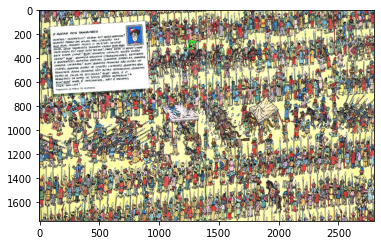

In [ ]:
images = np.load("./waldo_dataset/imgs_uint8.npy",allow_pickle=True)
labels = np.load("./waldo_dataset/labels_uint8.npy",allow_pickle=True)

sample_num = 9

y_list = np.where(labels[sample_num])[0]
x_list = np.where(labels[sample_num])[1]

x1 = min(x_list)
y1 = min(y_list)

x2 = max(x_list)
y2 = max(y_list)

print(x1,y1,x2,y2)
print("{} x {} \n {} x {}".format(images[sample_num].shape[0],images[sample_num].shape[1],(x2-x1),(y2-y1)))

sample_img = images[sample_num]
sample_box = [[x1,y1,x2,y2]]

plot_img = makeBox(sample_img,sample_box,['Wally'])

plt.imshow(plot_img)
plt.show()

In [ ]:
class DataAug():
  def __init__(self):
    self.iaa_flip = iaa.Fliplr(1)
  
  def flip(self, image, box):
    image, box = self.iaa_flip(image = image, bounding_boxes = np.array([box]))
    box = box.squeeze(0).tolist()

    return image, box
  
  def crop(self, image, box):
    box = box[0]

    left = np.random.randint(0,min(box[0],image.shape[1]/2))
    top = np.random.randint(0,min(box[1],image.shape[0]/2))
    right = np.random.randint(max(left+(image.shape[1]/2),box[2]),image.shape[1])
    bottom = np.random.randint(max(top+(image.shape[0]/2),box[3]),image.shape[0])

    image = image[top:bottom+1,left:right+1,:]

    x1_new = box[0] - left
    y1_new = box[1] - top
    x2_new = box[2] - left
    y2_new = box[3] - top
    box = [[x1_new,y1_new,x2_new,y2_new]]
    return image, box
    
  def random_aug(self, image, box):
    switch = np.random.randint(0,4) #0~3, 3이면 no aug
    if switch == 0:
      image, box = self.flip(image, box)
    elif switch == 1:
      image, box = self.crop(image, box)
    elif switch == 2:
      image, box = self.crop(image, box)
      image, box = self.flip(image, box)
    
    return image, box

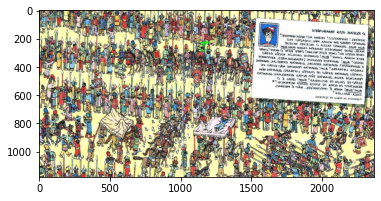

In [ ]:
DA = DataAug()
image_aug,bbs_aug = DA.random_aug(sample_img, sample_box)

plot_image = makeBox(image_aug,bbs_aug,['wally'])
plt.imshow(plot_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[{'boxes': tensor([[[1593,  728, 1650,  808]]], device='cuda:0'), 'labels': tensor([[1]], device='cuda:0')}]
torch.Size([1, 3, 1200, 1960])


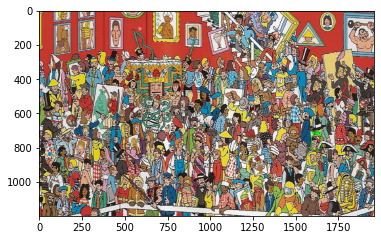

In [ ]:
class Wally(Dataset):

  def __init__(self):
    self.DA = DataAug()
    self.transform = transforms.ToTensor()
    self.images = np.load("./waldo_dataset/imgs_uint8.npy",allow_pickle=True)
    self.labels = np.load("./waldo_dataset/labels_uint8.npy",allow_pickle=True)
    self.resize = iaa.Resize({"height": 1200, "width": 1960})

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, idx):

    image = self.images[idx]
    label = self.labels[idx]

    y_list = np.where(label)[0] #y좌표 우선
    x_list = np.where(label)[1]

    x1 = min(x_list)
    y1 = min(y_list)
    x2 = max(x_list)
    y2 = max(y_list)

    box = [[x1,y1,x2,y2]]

    image, box = self.DA.random_aug(image, box)

    image, box = self.resize(image = image, bounding_boxes = np.array([box]))
    box = box.squeeze(0).tolist()


    targets = []
    d = {}
    d['boxes'] = torch.tensor(box,device=device)
    d['labels'] = torch.tensor([1],dtype=torch.int64,device = device)
    targets.append(d)
    
    return self.transform(image), targets

dataset = Wally()
dataloader = DataLoader(dataset,shuffle=True)

for i, (image, targets) in enumerate(dataloader):
  test_image = image
  test_target = targets
  if i == 0 : break

print(test_target)
print(test_image.shape)
plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(),test_target[0]['boxes'].squeeze(0),['wally'])
plt.imshow(plot_image)

In [ ]:
backbone = torchvision.models.vgg16(pretrained=True).features[:-1]
backbone_out = 512

backbone.out_channels = backbone_out

anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((8,16,32,64),),aspect_ratios=((0.5, 1.0, 2.0),))

resolution = 9

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=resolution, sampling_ratio=2)

box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,2) #2개 class

model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 1200, max_size = 1960,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 24000, rpn_pre_nms_top_n_test = 24000,
                   rpn_post_nms_top_n_train=1000, rpn_post_nms_top_n_test=500,
                   rpn_nms_thresh=0.5,rpn_fg_iou_thresh=0.7, rpn_bg_iou_thresh=0.3,
                   rpn_batch_size_per_image=256, rpn_positive_fraction=0.5,
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.05, box_nms_thresh=0.7,box_detections_per_img=300,
                   box_fg_iou_thresh=0.7, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 )
#roi head 있으면 num_class = None으로 함

for param in model.rpn.parameters():
  torch.nn.init.normal_(param,mean = 0.0, std=0.01)

for name, param in model.roi_heads.named_parameters():
  if "bbox_pred" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.001)
  elif "weight" in name:
    torch.nn.init.normal_(param,mean = 0.0, std=0.01)
  if "bias" in name:
    torch.nn.init.zeros_(param)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
def Total_Loss(loss):
  loss_objectness = loss['loss_objectness']
  loss_rpn_box_reg = loss['loss_rpn_box_reg']
  loss_classifier = loss['loss_classifier']
  loss_box_reg = loss['loss_box_reg']

  rpn_total = loss_objectness + 10*loss_rpn_box_reg
  fast_rcnn_total = loss_classifier + loss_box_reg

  total_loss = rpn_total + fast_rcnn_total

  return total_loss

In [ ]:
#Train

total_epoch = 150

loss_sum = 0

model.to(device)

optimizer = torch.optim.Adam(params = model.parameters(),lr = 0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer = optimizer, step_size= 10, gamma= 0.9)

print("Training Start")
model.train()

start = time.time()

for epoch in range(total_epoch):

  dataset = Wally()
  dataloader = DataLoader(dataset,shuffle=True)

  for i, (image,targets)in enumerate(dataloader):

    optimizer.zero_grad()

    targets[0]['boxes'].squeeze_(0)
    targets[0]['labels'].squeeze_(0)
    
    loss = model(image.to(device),targets)
    total_loss = Total_Loss(loss)
    loss_sum += total_loss
    
    total_loss.backward()
    optimizer.step()
    
  end = time.time()
  print("Epoch {} | Loss: {} | Duration: {} sec".format(epoch,(loss_sum/i).item(),int((end-start))))
  loss_sum = 0
  scheduler.step()
  start = time.time()

torch.save(model.state_dict(),"/content/drive/My Drive/Faster_RCNN/Wally.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[ 412.0809,   91.3944,  468.3621,  148.5397],
        [1805.4629,  809.3066, 1862.3433,  868.0181]], device='cuda:0',
       grad_fn=<StackBackward>)


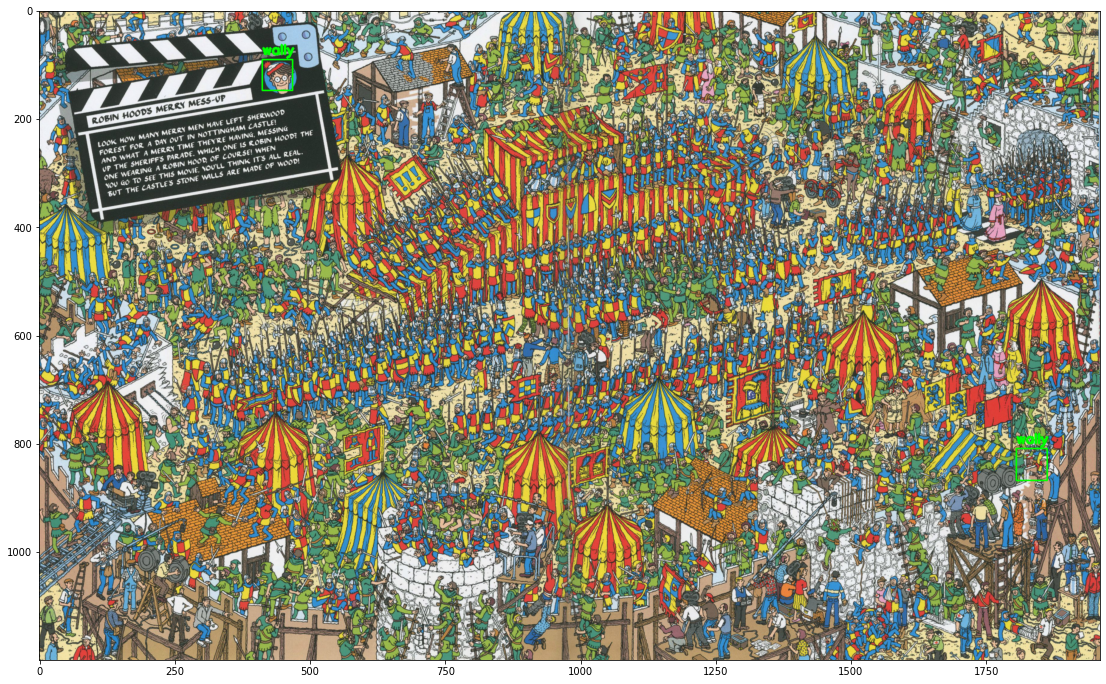

In [ ]:
#Eval

model.to(device)
model.load_state_dict(torch.load("/content/drive/My Drive/Faster_RCNN/Wally_best.pth",map_location=device))
resize = transforms.Resize((1200,1960))
model.roi_heads.score_thresh = 0.1
model.roi_heads.nms_thresh = 0.001
model.roi_heads.detections_per_img = 5

image_list = os.listdir("/content/waldo_testset/")

model.eval()
to_tensor = transforms.ToTensor()
test_image = Image.open("/content/waldo_testset/"+image_list[4])
#test_image = Image.open("/content/543.jpg") #외부 이미지 사용
test_image = resize(test_image)

test_image = to_tensor(test_image).unsqueeze(0)
predictions = model(test_image.to(device))
boxes = predictions[0]['boxes']
print(boxes)
plot_image = makeBox(test_image.squeeze().permute(1,2,0).numpy(),boxes,['wally' for i in range(len(boxes))])
plt.figure(figsize=(19,14))
plt.imshow(plot_image)
